In [7]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

from numba import njit, prange

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 2
bifurcate_time = .8
sgm = 5
threshold = 70
S = 250
R_initial = 32
eta = S*.03

In [3]:
strong_Tin = [.512]
medium_Tin = [.064, .128, .256]
weak = [0, .032]
medium_Tout = [-.256, -.128, -.064]
strong_Tout = [-.512]
coh_lst = [strong_Tin, medium_Tin, weak, medium_Tout, strong_Tout]

In [4]:
@njit(parallel=True, fastmath=True)
def get_dynamic_arr(coh, a, b):

    alpha = a

    active_trials = np.zeros(int(dur/dt))
    active_trials[0] = 10240

    RT_arr = np.zeros(int(dur/dt))
    RT_arr[0] = 0

    for i in prange(10240):

        beta = 0
        V1, V2 = S, S
        pass_threshold = False

        R1_arr = np.zeros(int(dur/dt))
        R2_arr = np.zeros(int(dur/dt))
        R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
        R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

        G1_arr = np.zeros(int(dur/dt))
        G2_arr = np.zeros(int(dur/dt))
        G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

        D1_arr = np.zeros(int(dur/dt))
        D2_arr = np.zeros(int(dur/dt))
        D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

        noise_R1 = np.zeros(int(dur/dt))
        noise_R2 = np.zeros(int(dur/dt))
        noise_G1 = np.zeros(int(dur/dt))
        noise_G2 = np.zeros(int(dur/dt))
        noise_D1 = np.zeros(int(dur/dt))
        noise_D2 = np.zeros(int(dur/dt))

        for ti in range(1, int(dur/dt)):

            if ti == bifurcate_time/dt:
                    beta = b
                    V1 = S*(1+coh)
                    V2 = S*(1-coh)

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                    V1 = S*(1+coh) + np.random.randn() * eta
                    V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if not pass_threshold:
                active_trials[ti] += 1
                RT_arr[ti] += R1_arr[ti]

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                pass_threshold = True

            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                pass_threshold = True

    return RT_arr, active_trials

In [5]:
def coh_ave_dynamic(a, b):

    strong_Tin_dynamic = np.zeros(int(dur/dt))
    medium_Tin_dynamic = np.zeros(int(dur/dt))
    weak_dynamic = np.zeros(int(dur/dt))
    medium_Tout_dynamic = np.zeros(int(dur/dt))
    strong_Tout_dynamic = np.zeros(int(dur/dt))
    final_dynamic = [strong_Tin_dynamic, medium_Tin_dynamic, weak_dynamic, medium_Tout_dynamic, strong_Tout_dynamic]

    for ind, coh_group in enumerate(coh_lst):

        cur_dynamic = np.zeros(int(dur/dt))
        cur_active_trials = np.zeros(int(dur/dt))
        stop = 0

        for coh in coh_group:
            temp_dynamic, temp_active_trials = get_dynamic_arr(coh, a, b)
            cur_dynamic = np.add(cur_dynamic, temp_dynamic)
            cur_active_trials = np.add(cur_active_trials, temp_active_trials)

        for sec, trial_num in enumerate(cur_active_trials):
            if trial_num < 10240/2 * len(coh_group):
                stop = sec
                break

        final_dynamic[ind] = np.divide(cur_dynamic[:stop], cur_active_trials[:stop])

    return final_dynamic

In [181]:
def draw_dynamic(ax, dynamic_arr, title, a, b, legend_loc='best'):
    ax.plot(dynamic_arr[0][700:], label="Strong $T_{in}$", color='lightgreen')
    ax.plot(dynamic_arr[1][700:], label="Medium $T_{in}$", color='forestgreen')
    ax.plot(dynamic_arr[2][700:], label="Weak", color='silver')
    ax.plot(dynamic_arr[3][700:], label="Medium $T_{out}$", color='darkorange')
    ax.plot(dynamic_arr[4][700:], label="Strong $T_{out}$", color='gold')
    ax.set_title("%s Condition (α=%d β=%.1f)" % (title, a, b))
    ax.set_xlabel("Time from Dots Onset (ms)")
    ax.set_ylabel("Firing Rate (Hz)")
    ax.legend(loc=legend_loc)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks(np.arange(0, int(ax.get_xlim()[1]), 100))
    ax.xaxis.set_ticklabels(np.arange(-100, int(ax.get_xlim()[1]-100), 100))

    ax.spines.bottom.set_position(('data', 15))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.annotate('Input', (920, 9.5), color='black', fontsize=15)
    ax.hlines(y=10, xmin=0, xmax=100, color='mediumpurple', linestyle='dashed', linewidth=1.5)
    ax.hlines(y=10, xmin=100, xmax=900, color='rebeccapurple', linewidth=1.5)

    ax.annotate('Disinhibition', (920, 5.5), color='black', fontsize=15)
    ax.hlines(y=5, xmin=0, xmax=100, color='lightcoral', linewidth=1.5)
    ax.vlines(x=100, ymin=5, ymax=7, color='indianred', linewidth=1.5)
    ax.hlines(y=7, xmin=100, xmax=900, color='brown', linewidth=1.5)

    ax.xaxis.set_label_coords(.5, -.005)

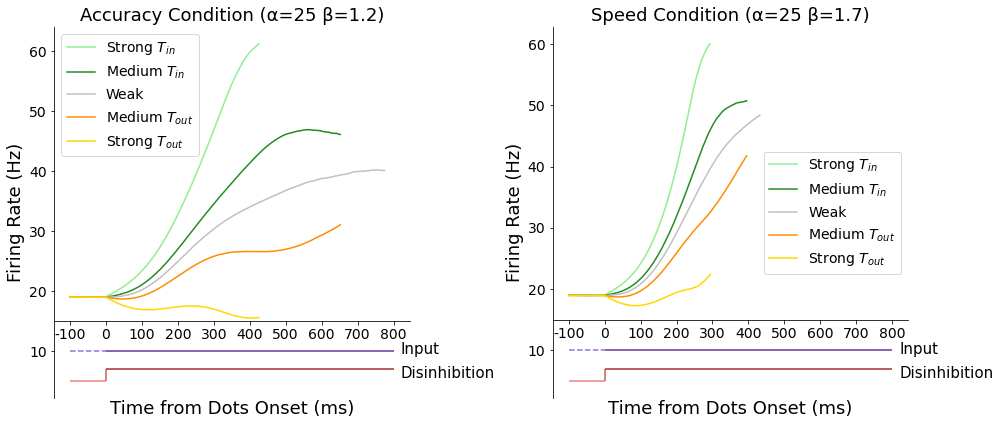

In [183]:
fig, (acc_ax, speed_ax) = plt.subplots(1, 2, figsize=(14,6), sharex=True)
accuracy_dynamic = coh_ave_dynamic(25, 1.2)
draw_dynamic(acc_ax, accuracy_dynamic, "Accuracy", 25, 1.2)
speed_dynamic = coh_ave_dynamic(25, 1.7)
draw_dynamic(speed_ax, speed_dynamic, "Speed", 25, 1.7, 'center right')
plt.tight_layout()

font_size = 18
params = {
        'legend.fontsize': 14,
         'axes.labelsize': font_size,
         'axes.titlesize': font_size,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
pylab.rcParams.update(params)

#plt.savefig('Accuracy and Speed Dynamics.eps', format='eps')
plt.savefig('Accuracy and Speed Dynamics.tiff', format='tiff')